# Hill of Towie Wind Turbine Power Prediction - Comprehensive EDA

## 🎯 Competition Goal
Predict power output for **Turbine 1** using data from nearby turbines (2, 3, 4, 5, 7) to minimize Mean Absolute Error (MAE) for turbine upgrade measurement scenarios.

## 📊 Dataset Overview
- **Training Data**: 2016-2019 for all turbines (1, 2, 3, 4, 5, 7)
- **Test Data**: 2020 for turbines 2, 3, 4, 5, 7 only (Turbine 1 is the target)
- **Target**: Active power of Turbine 1 (column: `target`)
- **Evaluation**: MAE on periods where `is_valid=True`

## 🔍 Analysis Objectives
1. Understand wind turbine power relationships
2. Analyze inter-turbine correlations and wake effects
3. Explore weather patterns using ERA5 data
4. Identify temporal patterns in power generation
5. Develop feature engineering strategies
6. Validate data quality and operational states

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Configure visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Add src to path for imports
import sys
from pathlib import Path
sys.path.append('../src')

# Constants from the getting started notebook
TARGET_COL = "target"
FULL_10MIN = 600  # full counter value for 10min interval
TURBINE_IDS = [1, 2, 3, 4, 5, 7]  # Note: Turbine 6 is missing
OTHER_TURBINE_IDS = [2, 3, 4, 5, 7]  # Turbines we can use for prediction

print("Libraries imported successfully!")
print(f"Target column: {TARGET_COL}")
print(f"Available turbines: {TURBINE_IDS}")
print(f"Predictor turbines: {OTHER_TURBINE_IDS}")

Libraries imported successfully!
Target column: target
Available turbines: [1, 2, 3, 4, 5, 7]
Predictor turbines: [2, 3, 4, 5, 7]


## 1. Data Loading and Initial Inspection

In [20]:
# Load datasets
from config import TRAIN_FILE, TEST_FILE, SAMPLE_SUBMISSION_FILE

print("Loading datasets...")
train_df = pd.read_parquet(TRAIN_FILE)
test_df = pd.read_parquet(TEST_FILE)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_FILE)

print(f"\n📊 Dataset Shapes:")
print(f"  Training data: {train_df.shape} ({train_df.shape[0]:,} samples, {train_df.shape[1]} features)")
print(f"  Test data: {test_df.shape} ({test_df.shape[0]:,} samples, {test_df.shape[1]} features)")
print(f"  Sample submission: {sample_submission.shape}")

# Check for target and is_valid columns
print(f"\n✅ Critical columns check:")
print(f"  'target' in train_df: {TARGET_COL in train_df.columns}")
print(f"  'is_valid' in train_df: {'is_valid' in train_df.columns}")
print(f"  'is_valid' in test_df: {'is_valid' in test_df.columns}")
print(f"  'target' in test_df: {TARGET_COL in test_df.columns} (should be False)")

Loading datasets...

📊 Dataset Shapes:
  Training data: (210384, 189) (210,384 samples, 189 features)
  Test data: (52704, 159) (52,704 samples, 159 features)
  Sample submission: (52704, 2)

✅ Critical columns check:
  'target' in train_df: True
  'is_valid' in train_df: True
  'is_valid' in test_df: True
  'target' in test_df: False (should be False)


In [21]:
# Display first few rows
print("\n🔍 First 3 rows of training data:")
display(train_df.head(3))

print("\n🔍 First 3 rows of test data:")
display(test_df.head(3))


🔍 First 3 rows of training data:


,TimeStamp_StartFormat,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,...,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid,target
0,2016-01-01 00:00:00+00:00,6.085917,5.830675,6.613091,6.998510,7.645727,7.040790,2.0,1.1,1.6,...,976.166321,0.0,6.080296,10.040418,233.695404,236.784729,13.0,-210384,True,352.522308
1,2016-01-01 00:10:00+00:00,5.824693,5.810768,5.895642,6.521900,6.413868,6.599652,2.1,2.2,1.9,...,982.179504,100.0,3.301515,6.958448,178.264328,187.431320,6.9,-210383,True,294.078888
2,2016-01-01 00:20:00+00:00,7.100180,6.386981,7.606015,7.695034,7.812548,7.469052,2.2,2.1,0.0,...,985.240540,78.0,3.478505,4.648656,198.435043,198.824799,7.7,-210382,True,587.302795



🔍 First 3 rows of test data:


,TimeStamp_StartFormat,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,...,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid
0,2020-01-01 00:00:00+00:00,11.16164,10.88820,11.86938,11.86918,11.67452,8.30,7.78,9.75,9.13,...,0.0,994.515015,18.0,4.808326,9.484725,224.999893,227.563812,9.7,0,True
1,2020-01-01 00:10:00+00:00,11.30721,10.86559,12.97147,12.50372,11.38912,7.88,6.94,10.07,9.44,...,0.0,1000.559082,95.0,2.785677,5.247857,201.037582,210.963684,4.4,1,True
2,2020-01-01 00:20:00+00:00,11.27332,10.89379,12.21393,12.14904,11.12704,8.50,6.94,9.65,9.96,...,0.0,989.992554,68.0,5.803448,9.226592,271.974884,274.350983,11.1,2,True


## 2. Understanding the Data Structure

In [ ]:
# Analyze column structure
def analyze_columns(df):
    """Analyze and categorize columns by turbine and type"""
    columns_by_turbine = {i: [] for i in TURBINE_IDS}
    era5_cols = []
    other_cols = []
    
    for col in df.columns:
        if ';' in col:
            # Turbine-specific column
            field, turbine_id = col.rsplit(';', 1)
            try:
                turbine_id = int(turbine_id)
                if turbine_id in columns_by_turbine:
                    columns_by_turbine[turbine_id].append(field)
            except ValueError:
                other_cols.append(col)
        elif col.startswith('ERA5'):
            era5_cols.append(col)
        else:
            other_cols.append(col)
    
    return columns_by_turbine, era5_cols, other_cols

# Analyze training data columns
cols_by_turbine, era5_cols, other_cols = analyze_columns(train_df)

print("📋 Column Analysis:")
print(f"\n  ERA5 weather columns: {len(era5_cols)}")
print(f"  Other columns: {len(other_cols)}")
print(f"    - {other_cols[:10]}...")

print("\n  Columns per turbine:")
for turbine_id in TURBINE_IDS:
    n_cols = len(cols_by_turbine[turbine_id])
    print(f"    Turbine {turbine_id}: {n_cols} columns")
    if n_cols > 0:
        print(f"      Sample: {cols_by_turbine[turbine_id][:5]}...")

# Check which turbine columns are missing in test data
test_cols_by_turbine, _, _ = analyze_columns(test_df)
print("\n⚠️  Turbine 1 columns in test data:", len(test_cols_by_turbine[1]), "(should be 0)")

📋 Column Analysis:

  ERA5 weather columns: 11
  Other columns: 4
    - ['TimeStamp_StartFormat', 'id', 'is_valid', 'target']...

  Columns per turbine:
    Turbine 1: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 'wtc_AcWindSp_stddev', 'wtc_ScYawPos_mean']...
    Turbine 2: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 'wtc_AcWindSp_stddev', 'wtc_ScYawPos_mean']...
    Turbine 3: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 'wtc_AcWindSp_stddev', 'wtc_ScYawPos_mean']...
    Turbine 4: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 'wtc_AcWindSp_stddev', 'wtc_ScYawPos_mean']...
    Turbine 5: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 'wtc_AcWindSp_stddev', 'wtc_ScYawPos_mean']...
    Turbine 7: 29 columns
      Sample: ['wtc_AcWindSp_mean', 'wtc_AcWindSp_min', 'wtc_AcWindSp_max', 

## 3. Target Variable Analysis (Turbine 1 Active Power)

In [23]:
# Analyze target variable
print("🎯 Target Variable Analysis (Turbine 1 Active Power)")
print("="*60)

# Basic statistics
target_data = train_df[TARGET_COL]
valid_target = train_df.loc[train_df['is_valid'], TARGET_COL]

print(f"\n📊 Target Statistics:")
print(f"  All data points: {len(target_data):,}")
print(f"  Valid data points (is_valid=True): {len(valid_target):,} ({100*len(valid_target)/len(target_data):.1f}%)")
print(f"\n  Statistics (valid data only):")
print(f"    Mean: {valid_target.mean():.2f} kW")
print(f"    Std: {valid_target.std():.2f} kW")
print(f"    Min: {valid_target.min():.2f} kW")
print(f"    25%: {valid_target.quantile(0.25):.2f} kW")
print(f"    50%: {valid_target.quantile(0.50):.2f} kW")
print(f"    75%: {valid_target.quantile(0.75):.2f} kW")
print(f"    Max: {valid_target.max():.2f} kW")

# Check if target is clipped at 0
print(f"\n  Negative values: {(valid_target < 0).sum()} (should be 0 - clipped at 0)")
print(f"  Zero values: {(valid_target == 0).sum():,} ({100*(valid_target == 0).sum()/len(valid_target):.1f}%)")

# Likely turbine rated power
print(f"\n  Likely rated power: ~{valid_target.max():.0f} kW")

🎯 Target Variable Analysis (Turbine 1 Active Power)

📊 Target Statistics:
  All data points: 210,384
  Valid data points (is_valid=True): 201,323 (95.7%)

  Statistics (valid data only):
    Mean: 663.64 kW
    Std: 715.83 kW
    Min: 0.00 kW
    25%: 86.04 kW
    50%: 370.61 kW
    75%: 1075.92 kW
    Max: 2304.95 kW

  Negative values: 0 (should be 0 - clipped at 0)
  Zero values: 26,454 (13.1%)

  Likely rated power: ~2305 kW


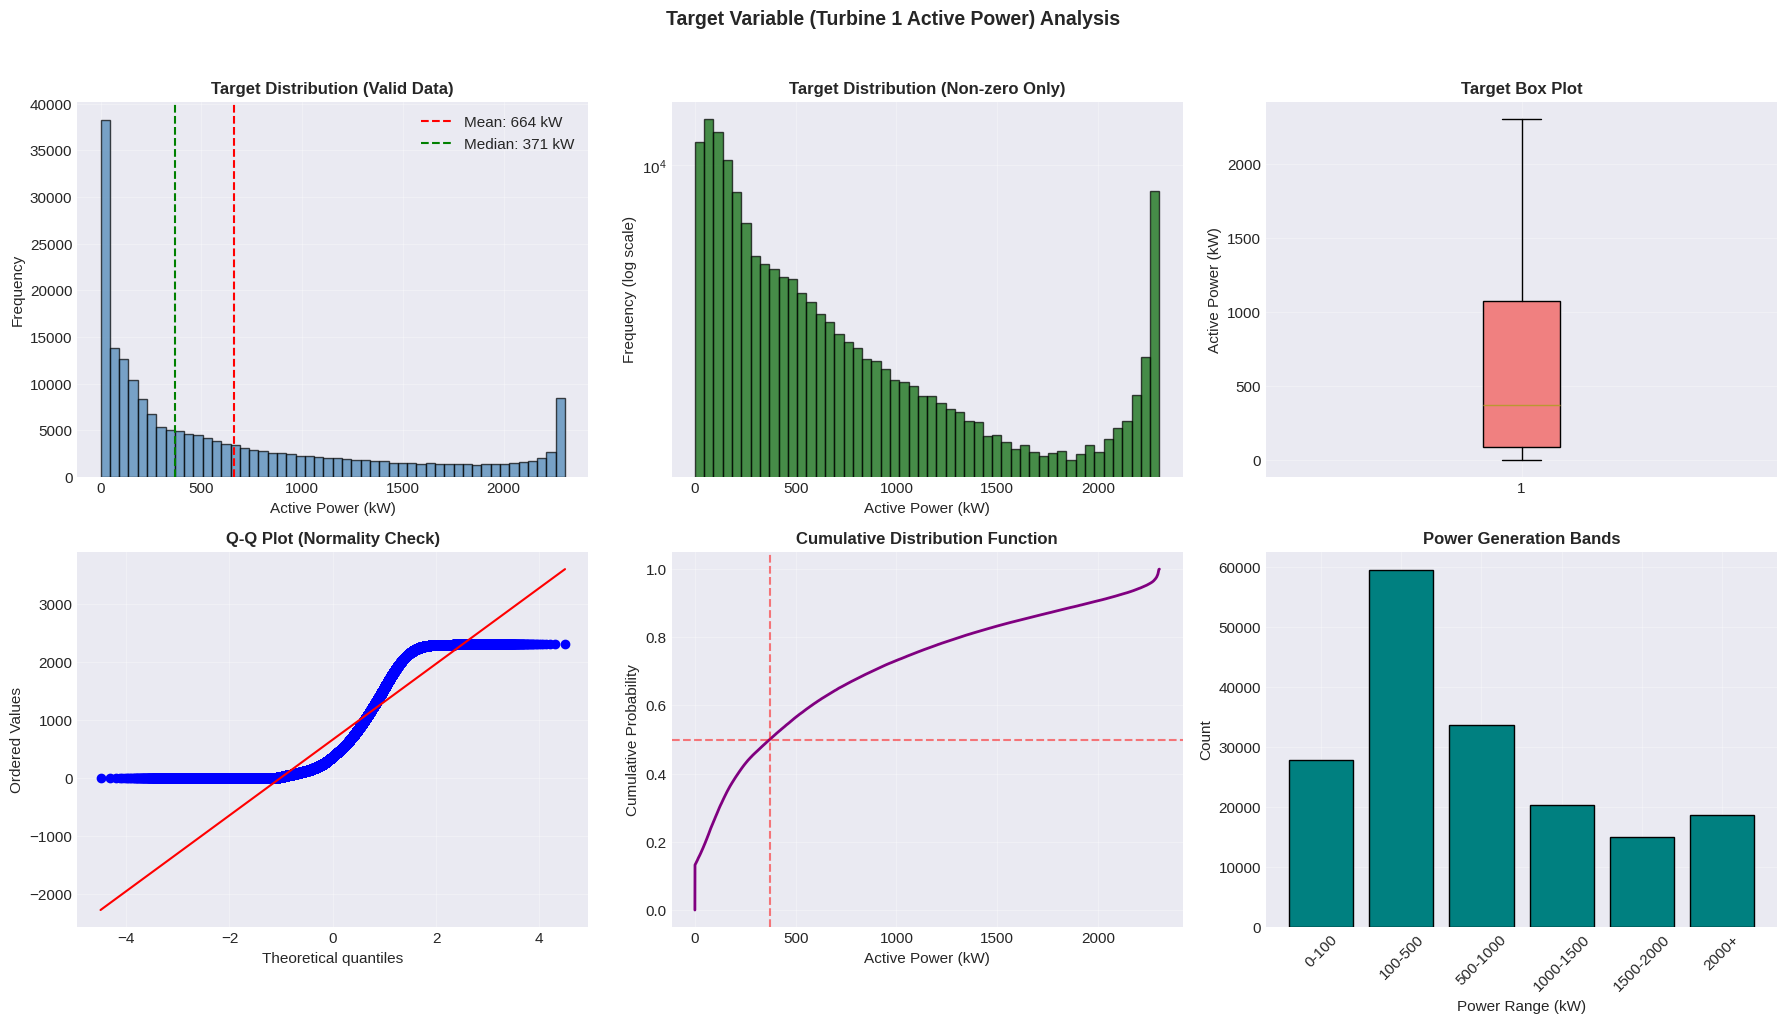

In [24]:
# Visualize target distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Histogram of all values
axes[0, 0].hist(valid_target, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Target Distribution (Valid Data)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Active Power (kW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(valid_target.mean(), color='red', linestyle='--', label=f'Mean: {valid_target.mean():.0f} kW')
axes[0, 0].axvline(valid_target.median(), color='green', linestyle='--', label=f'Median: {valid_target.median():.0f} kW')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log scale histogram (to see low power distribution)
valid_target_nonzero = valid_target[valid_target > 0]
axes[0, 1].hist(valid_target_nonzero, bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
axes[0, 1].set_title('Target Distribution (Non-zero Only)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Active Power (kW)')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot
box = axes[0, 2].boxplot(valid_target, vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('lightcoral')
axes[0, 2].set_title('Target Box Plot', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Active Power (kW)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Q-Q plot
stats.probplot(valid_target, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. CDF
sorted_target = np.sort(valid_target)
cdf = np.arange(1, len(sorted_target) + 1) / len(sorted_target)
axes[1, 1].plot(sorted_target, cdf, linewidth=2, color='purple')
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Active Power (kW)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(valid_target.median(), color='red', linestyle='--', alpha=0.5)

# 6. Power bands distribution
power_bands = pd.cut(valid_target, bins=[0, 100, 500, 1000, 1500, 2000, 2500], 
                     labels=['0-100', '100-500', '500-1000', '1000-1500', '1500-2000', '2000+'])
band_counts = power_bands.value_counts().sort_index()
axes[1, 2].bar(range(len(band_counts)), band_counts.values, color='teal', edgecolor='black')
axes[1, 2].set_xticks(range(len(band_counts)))
axes[1, 2].set_xticklabels(band_counts.index, rotation=45)
axes[1, 2].set_title('Power Generation Bands', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Power Range (kW)')
axes[1, 2].set_ylabel('Count')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Target Variable (Turbine 1 Active Power) Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Operational State Analysis (is_valid flag)

In [25]:
# Analyze is_valid flag
print("🔧 Operational State Analysis (is_valid flag)")
print("="*60)

# is_valid statistics
train_valid_pct = train_df['is_valid'].mean() * 100
test_valid_pct = test_df['is_valid'].mean() * 100

print(f"\n📊 Valid Operation Statistics:")
print(f"  Training data:")
print(f"    Valid: {train_df['is_valid'].sum():,} ({train_valid_pct:.1f}%)")
print(f"    Invalid: {(~train_df['is_valid']).sum():,} ({100-train_valid_pct:.1f}%)")
print(f"\n  Test data:")
print(f"    Valid: {test_df['is_valid'].sum():,} ({test_valid_pct:.1f}%)")
print(f"    Invalid: {(~test_df['is_valid']).sum():,} ({100-test_valid_pct:.1f}%)")

# Check relationship with ShutdownDuration and wtc_ScReToOp_timeon
print("\n🔍 Validation Rule Check (is_valid = ShutdownDuration==0 AND wtc_ScReToOp_timeon==600):")

# Check for Turbine 1
if 'ShutdownDuration;1' in train_df.columns and 'wtc_ScReToOp_timeon;1' in train_df.columns:
    expected_valid = (train_df['ShutdownDuration;1'] == 0) & (train_df['wtc_ScReToOp_timeon;1'] == FULL_10MIN)
    match_pct = (train_df['is_valid'] == expected_valid).mean() * 100
    print(f"  Rule matches is_valid flag: {match_pct:.1f}%")
    
    # Check cases where they don't match
    if match_pct < 100:
        mismatches = train_df['is_valid'] != expected_valid
        print(f"  Mismatches: {mismatches.sum():,}")
        print("\n  Sample mismatches:")
        mismatch_df = train_df[mismatches][['is_valid', 'ShutdownDuration;1', 'wtc_ScReToOp_timeon;1', TARGET_COL]].head(5)
        display(mismatch_df)
else:
    print("  Cannot verify - columns not found")

🔧 Operational State Analysis (is_valid flag)

📊 Valid Operation Statistics:
  Training data:
    Valid: 201,323 (95.7%)
    Invalid: 9,061 (4.3%)

  Test data:
    Valid: 51,544 (97.8%)
    Invalid: 1,160 (2.2%)

🔍 Validation Rule Check (is_valid = ShutdownDuration==0 AND wtc_ScReToOp_timeon==600):
  Rule matches is_valid flag: 100.0%



📊 Target values when is_valid=False:
  Count: 9,061
  Mean: 49.63 kW
  Std: 226.87 kW
  Min: 0.00 kW
  Max: 2284.99 kW
  Zeros: 5,874 (64.8%)


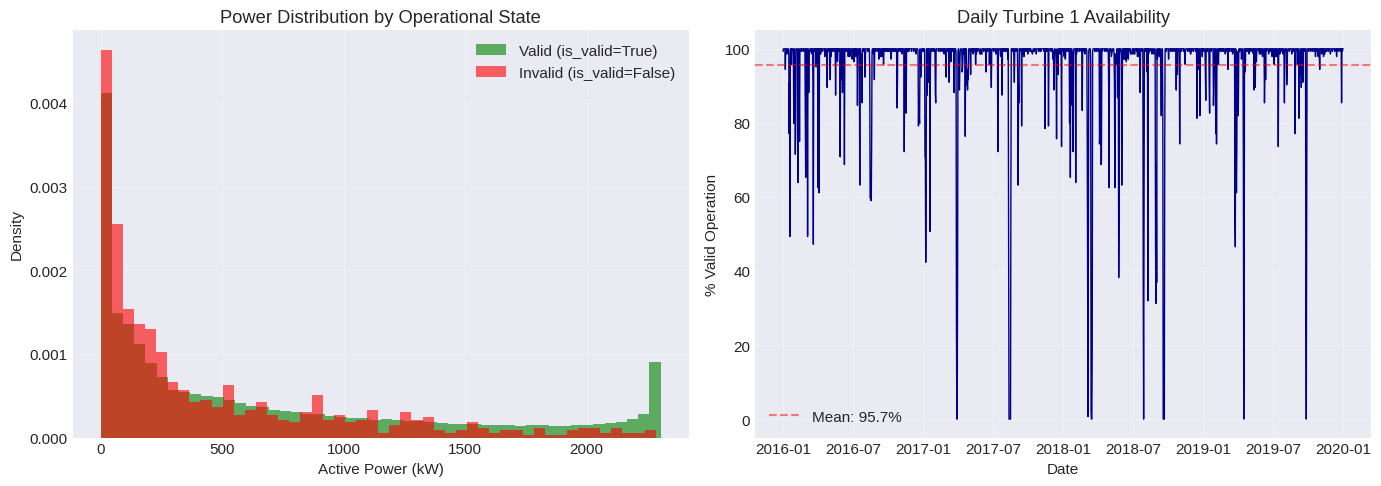

In [26]:
# Analyze target values when is_valid is False
invalid_target = train_df.loc[~train_df['is_valid'], TARGET_COL]

print("\n📊 Target values when is_valid=False:")
print(f"  Count: {len(invalid_target):,}")
print(f"  Mean: {invalid_target.mean():.2f} kW")
print(f"  Std: {invalid_target.std():.2f} kW")
print(f"  Min: {invalid_target.min():.2f} kW")
print(f"  Max: {invalid_target.max():.2f} kW")
print(f"  Zeros: {(invalid_target == 0).sum():,} ({100*(invalid_target == 0).sum()/len(invalid_target):.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compare distributions
axes[0].hist(valid_target, bins=50, alpha=0.6, label='Valid (is_valid=True)', color='green', density=True)
axes[0].hist(invalid_target[invalid_target > 0], bins=50, alpha=0.6, label='Invalid (is_valid=False)', color='red', density=True)
axes[0].set_xlabel('Active Power (kW)')
axes[0].set_ylabel('Density')
axes[0].set_title('Power Distribution by Operational State')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series of is_valid
train_df['TimeStamp'] = pd.to_datetime(train_df['TimeStamp_StartFormat'])
daily_valid = train_df.set_index('TimeStamp')['is_valid'].resample('D').mean()
axes[1].plot(daily_valid.index, daily_valid.values * 100, linewidth=1, color='darkblue')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('% Valid Operation')
axes[1].set_title('Daily Turbine 1 Availability')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(daily_valid.mean() * 100, color='red', linestyle='--', alpha=0.5, label=f'Mean: {daily_valid.mean()*100:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Inter-Turbine Correlation Analysis

In [27]:
# Extract active power columns for each turbine
power_cols = {}
for turbine_id in TURBINE_IDS:
    col_name = f'wtc_ActPower_mean;{turbine_id}'
    if col_name in train_df.columns:
        power_cols[turbine_id] = col_name

print("⚡ Inter-Turbine Power Correlation Analysis")
print("="*60)
print(f"\nFound active power columns for turbines: {list(power_cols.keys())}")

# Create correlation matrix for valid operation periods only
valid_data = train_df[train_df['is_valid']].copy()
power_df = valid_data[[col for col in power_cols.values()]].copy()
power_df.columns = [f'T{tid}' for tid in power_cols.keys()]

# Add target (which is Turbine 1's active power, clipped at 0)
power_df['T1_target'] = valid_data[TARGET_COL].values

# Calculate correlation matrix
corr_matrix = power_df.corr()

print("\n📊 Correlation with Turbine 1 (Target):")
target_corr = corr_matrix['T1_target'].sort_values(ascending=False)
for turbine, corr in target_corr.items():
    if turbine != 'T1_target':
        print(f"  {turbine}: {corr:.4f}")

⚡ Inter-Turbine Power Correlation Analysis

Found active power columns for turbines: [1, 2, 3, 4, 5, 7]

📊 Correlation with Turbine 1 (Target):
  T1: 1.0000
  T4: 0.9545
  T3: 0.9518
  T7: 0.9508
  T2: 0.9496
  T5: 0.9420


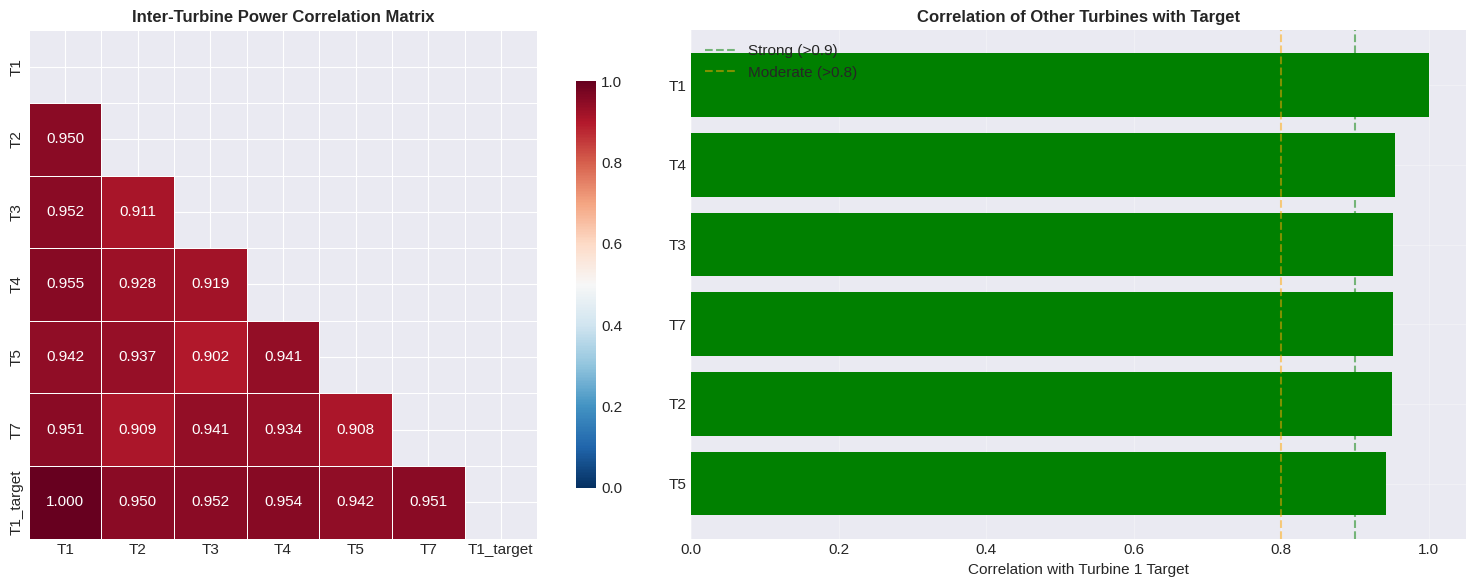


🎯 Top 3 predictor turbines for Turbine 1:
  T1: 1.0000
  T4: 0.9545
  T3: 0.9518


In [28]:
# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r', center=0.5,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=axes[0],
            vmin=0, vmax=1)
axes[0].set_title('Inter-Turbine Power Correlation Matrix', fontsize=12, fontweight='bold')

# Bar plot of correlations with target
target_corr_others = target_corr.drop('T1_target').sort_values(ascending=True)
colors = ['green' if x > 0.9 else 'orange' if x > 0.8 else 'red' for x in target_corr_others.values]
axes[1].barh(range(len(target_corr_others)), target_corr_others.values, color=colors)
axes[1].set_yticks(range(len(target_corr_others)))
axes[1].set_yticklabels(target_corr_others.index)
axes[1].set_xlabel('Correlation with Turbine 1 Target')
axes[1].set_title('Correlation of Other Turbines with Target', fontsize=12, fontweight='bold')
axes[1].axvline(0.9, color='green', linestyle='--', alpha=0.5, label='Strong (>0.9)')
axes[1].axvline(0.8, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.8)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Find best predictor turbines
best_predictors = target_corr_others.nlargest(3)
print(f"\n🎯 Top 3 predictor turbines for Turbine 1:")
for turbine, corr in best_predictors.items():
    print(f"  {turbine}: {corr:.4f}")

## 6. Power Curve Analysis

💨 Power Curve Analysis


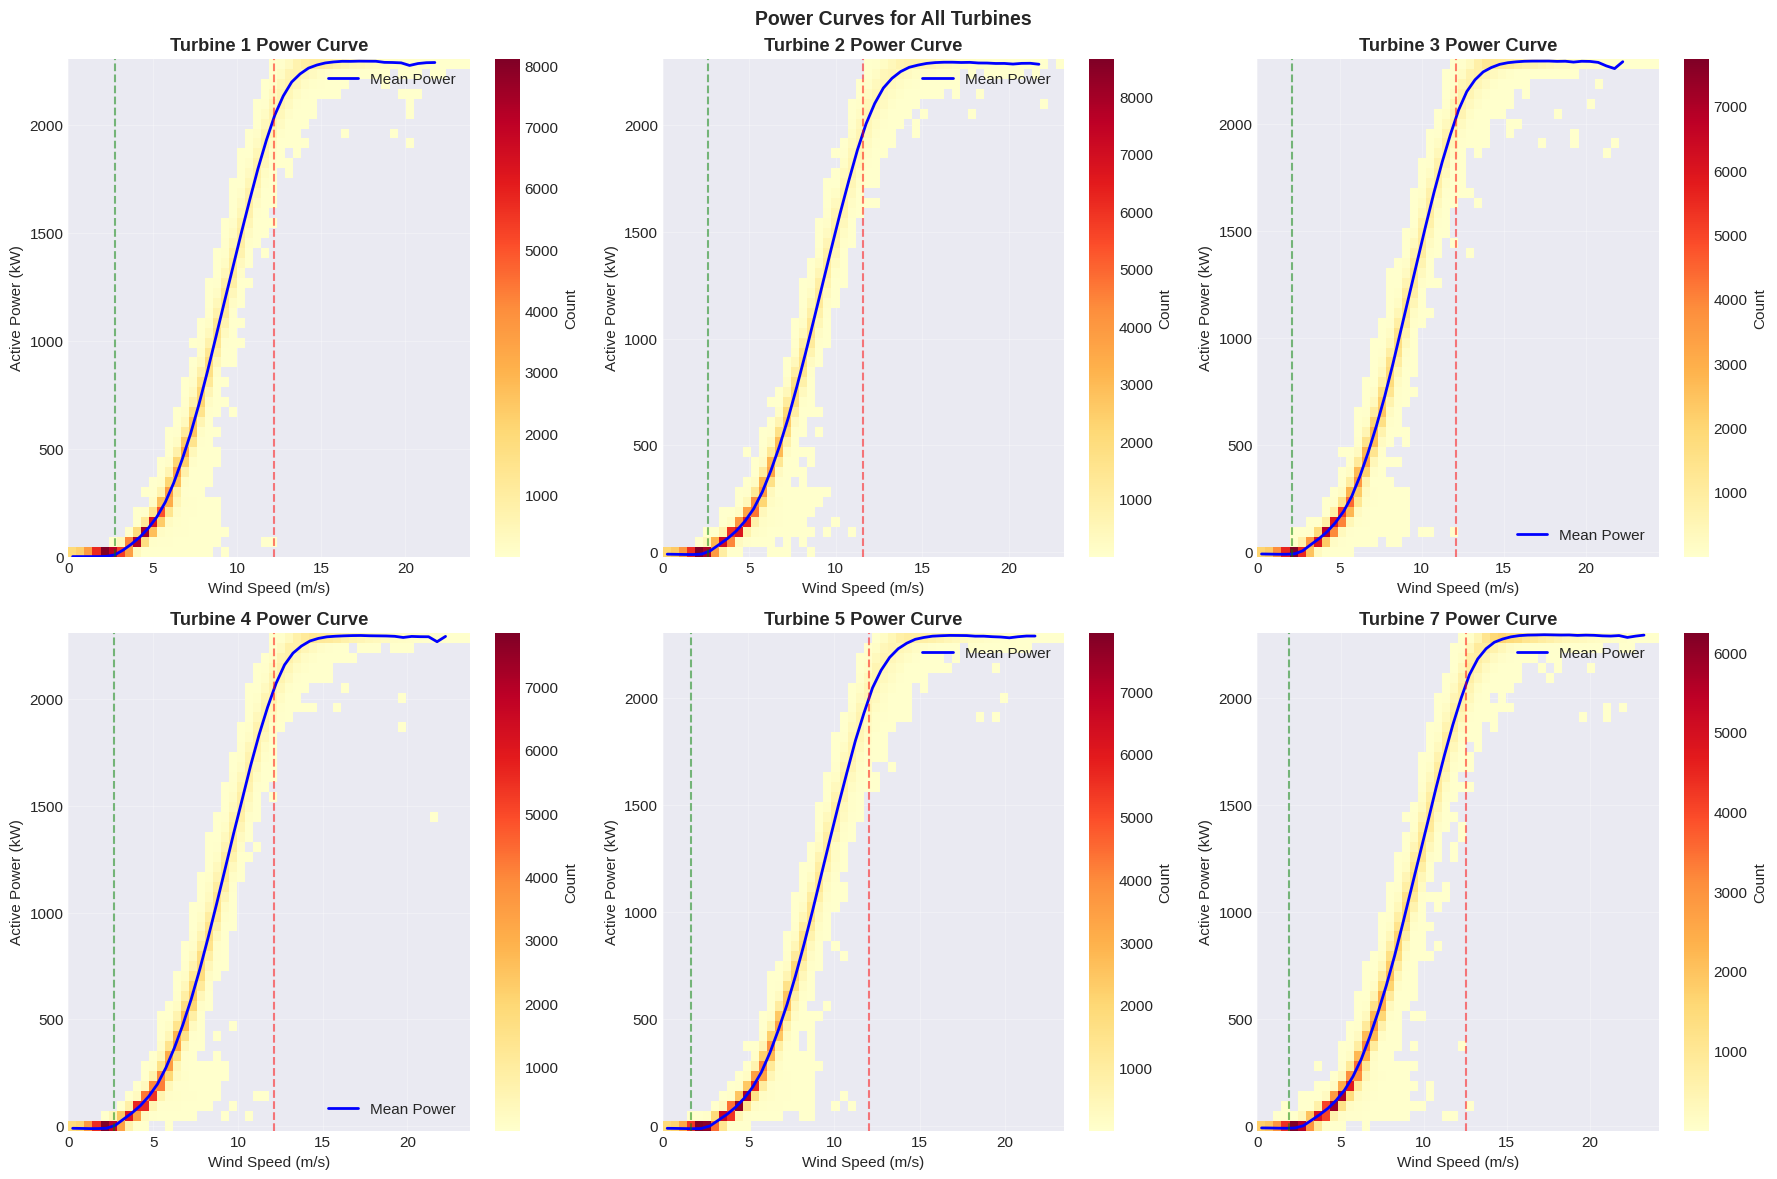

In [29]:
# Analyze power curves (Power vs Wind Speed)
print("💨 Power Curve Analysis")
print("="*60)

# Get wind speed and power for each turbine
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, turbine_id in enumerate(TURBINE_IDS):
    wind_col = f'wtc_AcWindSp_mean;{turbine_id}'
    power_col = f'wtc_ActPower_mean;{turbine_id}' if turbine_id != 1 else TARGET_COL
    
    if wind_col in train_df.columns and (power_col in train_df.columns or turbine_id == 1):
        # Use only valid data
        if turbine_id == 1:
            valid_mask = train_df['is_valid']
        else:
            # For other turbines, check their operational status
            shutdown_col = f'ShutdownDuration;{turbine_id}'
            op_col = f'wtc_ScReToOp_timeon;{turbine_id}'
            if shutdown_col in train_df.columns and op_col in train_df.columns:
                valid_mask = (train_df[shutdown_col] == 0) & (train_df[op_col] == FULL_10MIN)
            else:
                valid_mask = train_df['is_valid']  # fallback
        
        wind_speed = train_df.loc[valid_mask, wind_col]
        power = train_df.loc[valid_mask, power_col]
        
        # Remove NaN values
        mask = ~(wind_speed.isna() | power.isna())
        wind_speed = wind_speed[mask]
        power = power[mask]
        
        # Create 2D histogram for power curve
        ax = axes[idx]
        h = ax.hist2d(wind_speed, power, bins=[50, 50], cmap='YlOrRd', cmin=1)
        ax.set_xlabel('Wind Speed (m/s)')
        ax.set_ylabel('Active Power (kW)')
        ax.set_title(f'Turbine {turbine_id} Power Curve', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(h[3], ax=ax, label='Count')
        
        # Calculate and plot binned average
        wind_bins = np.arange(0, wind_speed.max() + 1, 0.5)
        binned_power = []
        bin_centers = []
        for i in range(len(wind_bins) - 1):
            mask = (wind_speed >= wind_bins[i]) & (wind_speed < wind_bins[i+1])
            if mask.sum() > 10:  # Only if enough points
                binned_power.append(power[mask].mean())
                bin_centers.append((wind_bins[i] + wind_bins[i+1]) / 2)
        
        if binned_power:
            ax.plot(bin_centers, binned_power, 'b-', linewidth=2, label='Mean Power')
            ax.legend()
        
        # Identify key wind speeds
        if len(power) > 0:
            # Cut-in wind speed (first non-zero power)
            producing_mask = power > 50  # More than 50 kW
            if producing_mask.any():
                cut_in = wind_speed[producing_mask].min()
                ax.axvline(cut_in, color='green', linestyle='--', alpha=0.5, label=f'Cut-in: {cut_in:.1f} m/s')
            
            # Rated wind speed (where power plateaus)
            high_power_mask = power > power.quantile(0.95)
            if high_power_mask.any():
                rated_wind = wind_speed[high_power_mask].min()
                ax.axvline(rated_wind, color='red', linestyle='--', alpha=0.5, label=f'Rated: {rated_wind:.1f} m/s')

plt.suptitle('Power Curves for All Turbines', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Temporal Patterns Analysis

📅 Temporal Patterns Analysis


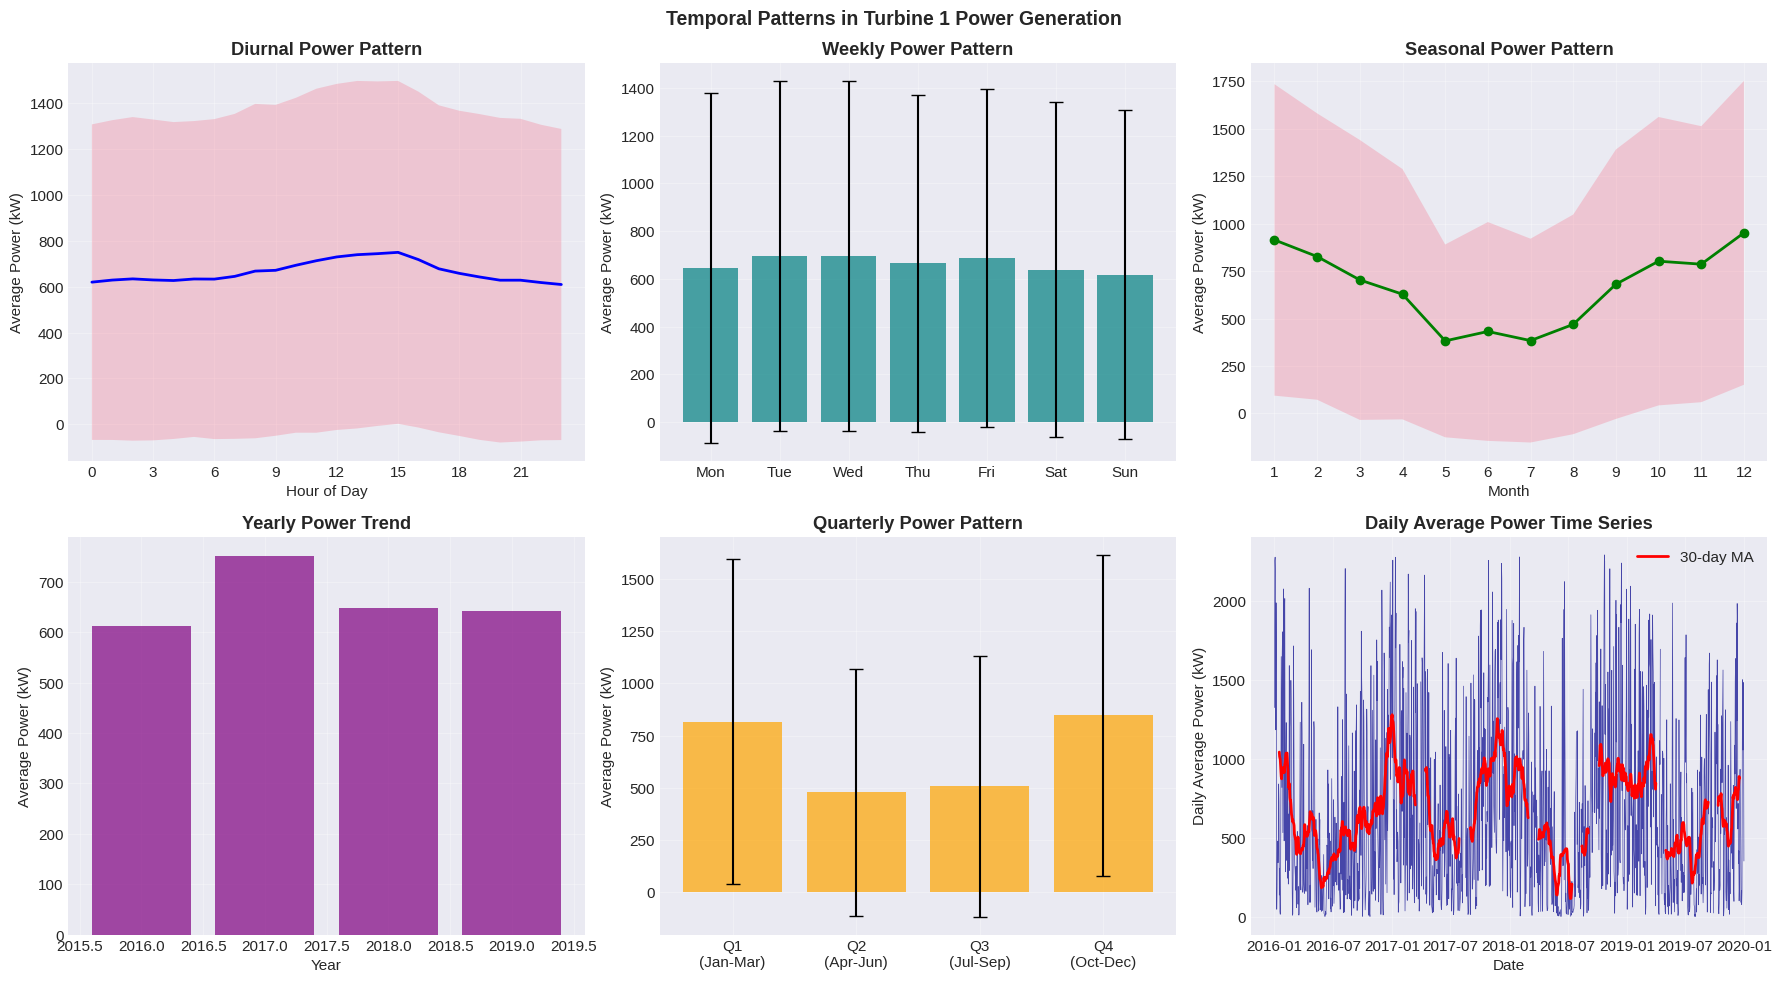


📊 Temporal Insights:
  Peak hour: 15:00 (750 kW)
  Lowest hour: 23:00 (609 kW)
  Best month: 12 (952 kW)
  Worst month: 5 (383 kW)
  Best quarter: Q4 (847 kW)


In [30]:
# Analyze temporal patterns
print("📅 Temporal Patterns Analysis")
print("="*60)

# Add time features
train_df['hour'] = train_df['TimeStamp'].dt.hour
train_df['day'] = train_df['TimeStamp'].dt.day
train_df['month'] = train_df['TimeStamp'].dt.month
train_df['year'] = train_df['TimeStamp'].dt.year
train_df['dayofweek'] = train_df['TimeStamp'].dt.dayofweek
train_df['quarter'] = train_df['TimeStamp'].dt.quarter

# Use only valid data for temporal analysis
valid_temporal = train_df[train_df['is_valid']].copy()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Hourly pattern
hourly_avg = valid_temporal.groupby('hour')[TARGET_COL].agg(['mean', 'std'])
axes[0, 0].plot(hourly_avg.index, hourly_avg['mean'], 'b-', linewidth=2)
axes[0, 0].fill_between(hourly_avg.index, 
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.3)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Power (kW)')
axes[0, 0].set_title('Diurnal Power Pattern', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 3))

# 2. Day of week pattern
dow_avg = valid_temporal.groupby('dayofweek')[TARGET_COL].agg(['mean', 'std'])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_avg['mean'], yerr=dow_avg['std'], capsize=5, color='teal', alpha=0.7)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Average Power (kW)')
axes[0, 1].set_title('Weekly Power Pattern', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Monthly pattern
monthly_avg = valid_temporal.groupby('month')[TARGET_COL].agg(['mean', 'std'])
axes[0, 2].plot(monthly_avg.index, monthly_avg['mean'], 'g-', linewidth=2, marker='o')
axes[0, 2].fill_between(monthly_avg.index,
                        monthly_avg['mean'] - monthly_avg['std'],
                        monthly_avg['mean'] + monthly_avg['std'],
                        alpha=0.3)
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Power (kW)')
axes[0, 2].set_title('Seasonal Power Pattern', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(range(1, 13))

# 4. Yearly trend
yearly_avg = valid_temporal.groupby('year')[TARGET_COL].agg(['mean', 'count'])
axes[1, 0].bar(yearly_avg.index, yearly_avg['mean'], color='purple', alpha=0.7)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Power (kW)')
axes[1, 0].set_title('Yearly Power Trend', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. Quarterly pattern
quarterly_avg = valid_temporal.groupby('quarter')[TARGET_COL].agg(['mean', 'std'])
quarters = ['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)']
axes[1, 1].bar(range(4), quarterly_avg['mean'], yerr=quarterly_avg['std'], capsize=5, color='orange', alpha=0.7)
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(quarters)
axes[1, 1].set_ylabel('Average Power (kW)')
axes[1, 1].set_title('Quarterly Power Pattern', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Time series overview
daily_avg = valid_temporal.set_index('TimeStamp')[TARGET_COL].resample('D').mean()
axes[1, 2].plot(daily_avg.index, daily_avg.values, linewidth=0.5, color='darkblue', alpha=0.7)
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Daily Average Power (kW)')
axes[1, 2].set_title('Daily Average Power Time Series', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

# Add 30-day rolling average
rolling_avg = daily_avg.rolling(window=30, center=True).mean()
axes[1, 2].plot(rolling_avg.index, rolling_avg.values, 'r-', linewidth=2, label='30-day MA')
axes[1, 2].legend()

plt.suptitle('Temporal Patterns in Turbine 1 Power Generation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print insights
print("\n📊 Temporal Insights:")
print(f"  Peak hour: {hourly_avg['mean'].idxmax()}:00 ({hourly_avg['mean'].max():.0f} kW)")
print(f"  Lowest hour: {hourly_avg['mean'].idxmin()}:00 ({hourly_avg['mean'].min():.0f} kW)")
print(f"  Best month: {monthly_avg['mean'].idxmax()} ({monthly_avg['mean'].max():.0f} kW)")
print(f"  Worst month: {monthly_avg['mean'].idxmin()} ({monthly_avg['mean'].min():.0f} kW)")
print(f"  Best quarter: Q{quarterly_avg['mean'].idxmax()} ({quarterly_avg['mean'].max():.0f} kW)")

## 8. ERA5 Weather Data Analysis

🌤️ ERA5 Weather Data Analysis

Found 11 ERA5 weather features:
  - ERA5_temperature_2m
  - ERA5_relative_humidity_2m
  - ERA5_dew_point_2m
  - ERA5_precipitation
  - ERA5_surface_pressure
  - ERA5_cloud_cover
  - ERA5_wind_speed_10m
  - ERA5_wind_speed_100m
  - ERA5_wind_direction_10m
  - ERA5_wind_direction_100m
  - ERA5_wind_gusts_10m

📊 Top 10 Weather Features Correlated with Target:
  ERA5_wind_speed_100m: 0.5402
  ERA5_wind_speed_10m: 0.5214
  ERA5_wind_gusts_10m: 0.5030
  ERA5_surface_pressure: -0.1392
  ERA5_dew_point_2m: -0.1242
  ERA5_wind_direction_10m: 0.1193
  ERA5_wind_direction_100m: 0.1152
  ERA5_relative_humidity_2m: -0.0943
  ERA5_temperature_2m: -0.0802
  ERA5_precipitation: 0.0348


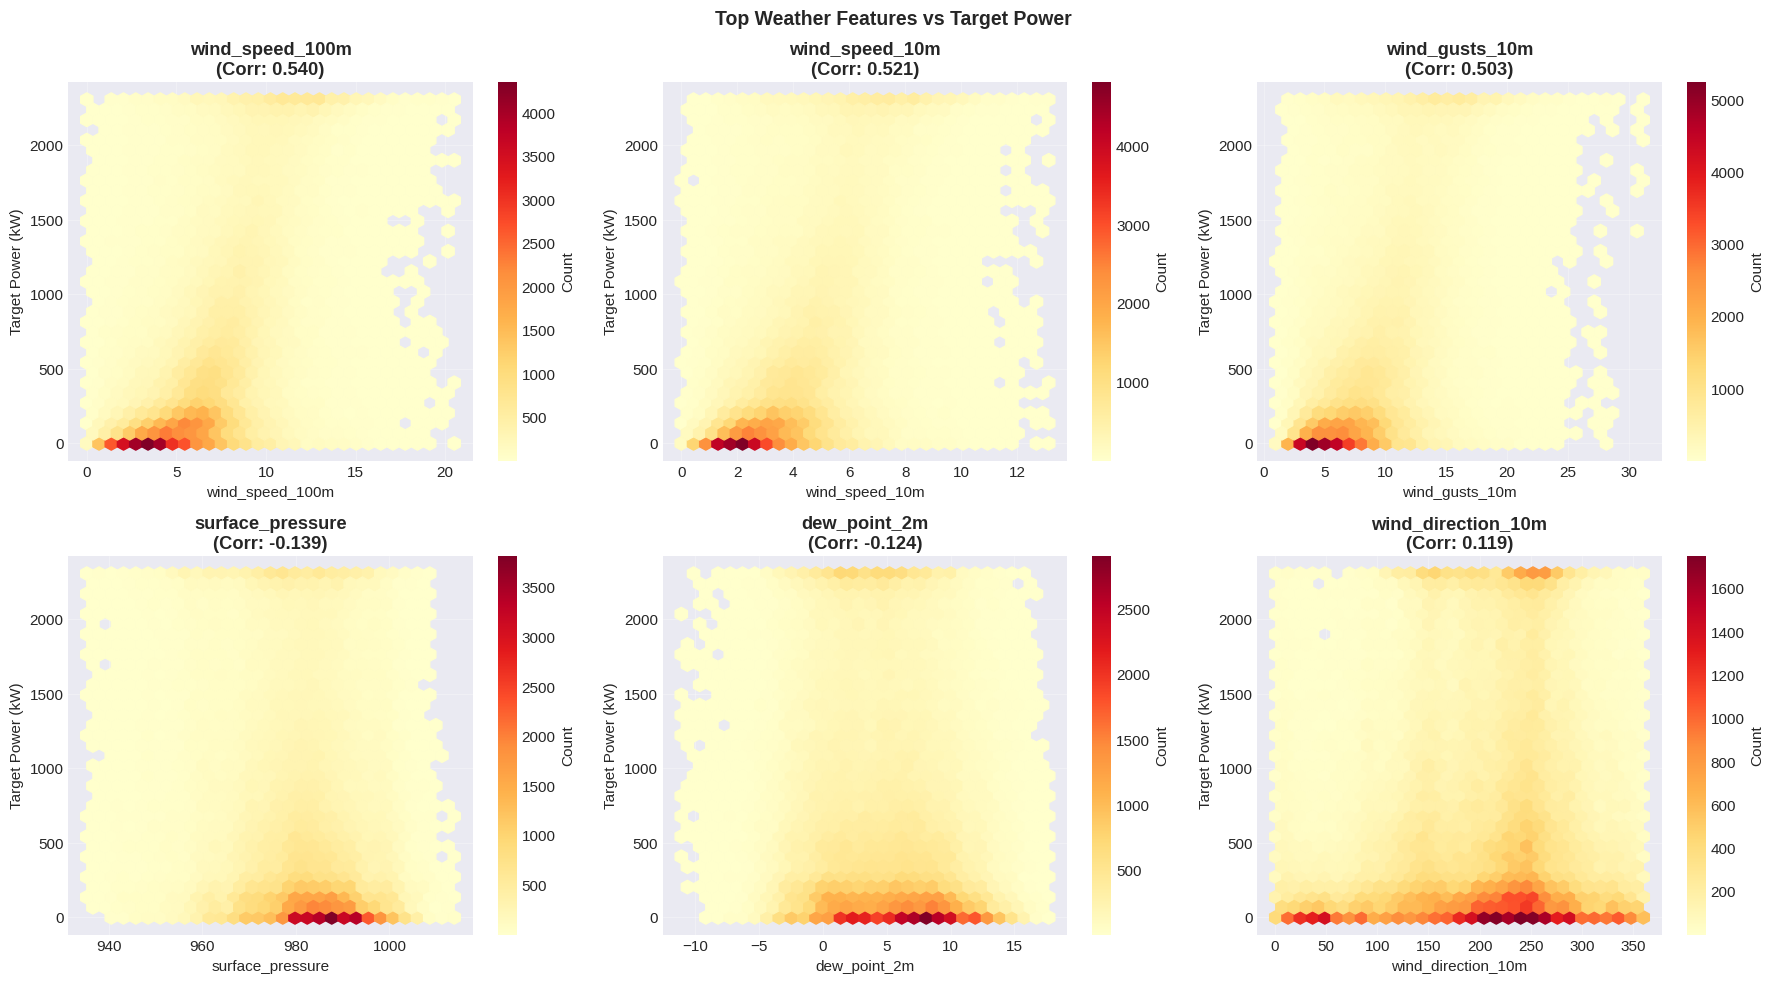

In [ ]:
# Analyze ERA5 weather features
print("🌤️ ERA5 Weather Data Analysis")
print("="*60)

# List ERA5 columns
era5_columns = [col for col in train_df.columns if col.startswith('ERA5')]
print(f"\nFound {len(era5_columns)} ERA5 weather features:")
for col in era5_columns:
    print(f"  - {col}")

# Analyze correlation of weather features with target
weather_corr = train_df[train_df['is_valid']][era5_columns + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL).sort_values(key=abs, ascending=False)

print("\n📊 Top 10 Weather Features Correlated with Target:")
for feature, corr in weather_corr.head(10).items():
    print(f"  {feature}: {corr:.4f}")

# Visualize top weather correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_weather = weather_corr.head(6)
for idx, (feature, corr) in enumerate(top_weather.items()):
    valid_data = train_df[train_df['is_valid']][[feature, TARGET_COL]].dropna()
    
    # Create scatter plot with hexbin
    h = axes[idx].hexbin(valid_data[feature], valid_data[TARGET_COL], 
                         gridsize=30, cmap='YlOrRd', mincnt=1)
    axes[idx].set_xlabel(feature.replace('ERA5_', ''))
    axes[idx].set_ylabel('Target Power (kW)')
    axes[idx].set_title(f'{feature.replace("ERA5_", "")}\n(Corr: {corr:.3f})', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    plt.colorbar(h, ax=axes[idx], label='Count')

plt.suptitle('Top Weather Features vs Target Power', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# TODO: Add overlay of original power curve and new averaged powercurve from the ERA5 features


💨 Wind Analysis (ERA5)

📊 Wind Speed Statistics:
  10m height: 4.27 ± 2.07 m/s
  100m height: 6.94 ± 3.19 m/s
  Wind shear (100m/10m): inf ± nan


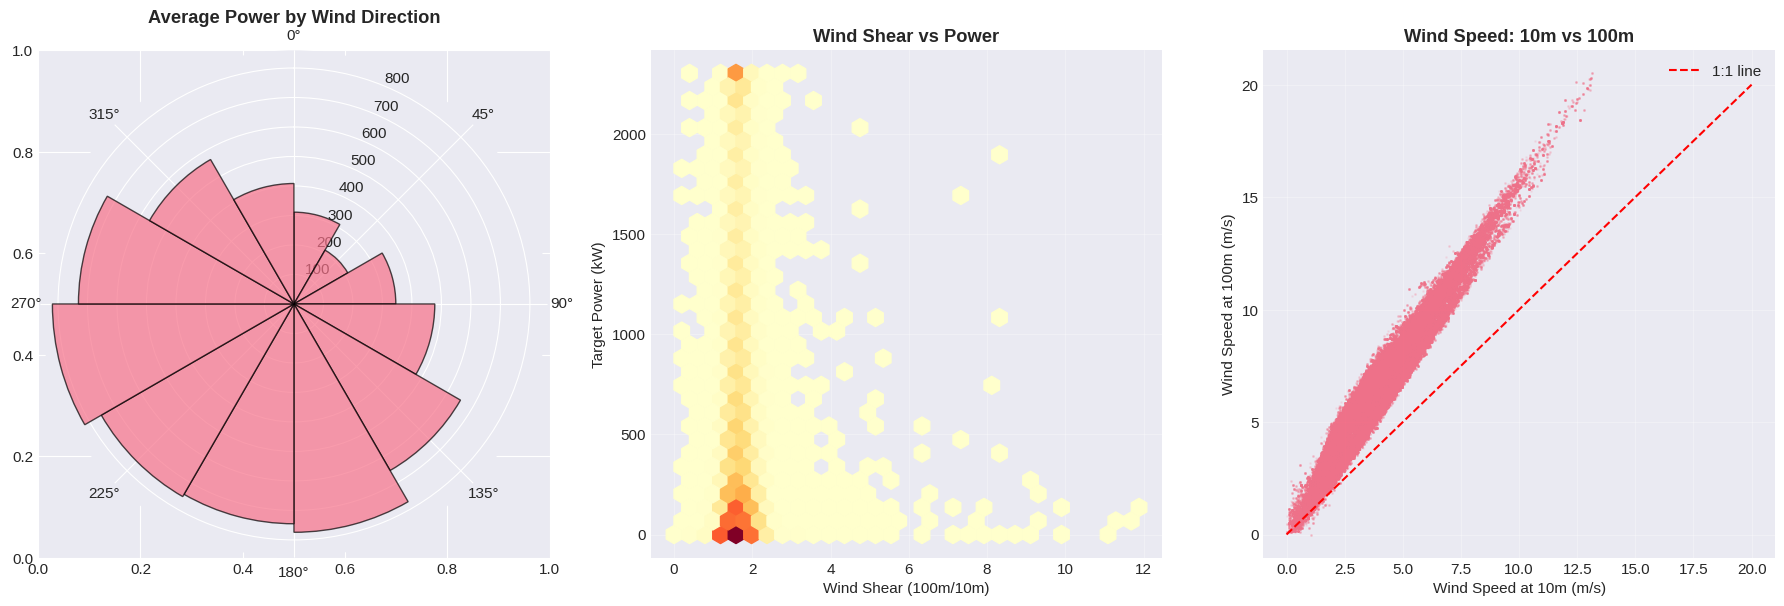

In [32]:
# Analyze wind speed and direction patterns
print("\n💨 Wind Analysis (ERA5)")
print("="*60)

# Wind speed at different heights
if 'ERA5_wind_speed_10m' in train_df.columns and 'ERA5_wind_speed_100m' in train_df.columns:
    valid_wind = train_df[train_df['is_valid']].copy()
    
    # Calculate wind shear
    valid_wind['wind_shear'] = valid_wind['ERA5_wind_speed_100m'] / valid_wind['ERA5_wind_speed_10m']
    
    print("\n📊 Wind Speed Statistics:")
    print(f"  10m height: {valid_wind['ERA5_wind_speed_10m'].mean():.2f} ± {valid_wind['ERA5_wind_speed_10m'].std():.2f} m/s")
    print(f"  100m height: {valid_wind['ERA5_wind_speed_100m'].mean():.2f} ± {valid_wind['ERA5_wind_speed_100m'].std():.2f} m/s")
    print(f"  Wind shear (100m/10m): {valid_wind['wind_shear'].mean():.3f} ± {valid_wind['wind_shear'].std():.3f}")
    
    # Visualize wind patterns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Wind rose (simplified)
    wind_dir = valid_wind['ERA5_wind_direction_100m']
    wind_speed = valid_wind['ERA5_wind_speed_100m']
    
    # Create wind direction bins
    dir_bins = np.arange(0, 361, 30)
    dir_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW']
    
    # Calculate average power by wind direction
    power_by_dir = []
    for i in range(len(dir_bins) - 1):
        mask = (wind_dir >= dir_bins[i]) & (wind_dir < dir_bins[i+1])
        if mask.sum() > 0:
            power_by_dir.append(valid_wind.loc[mask, TARGET_COL].mean())
        else:
            power_by_dir.append(0)
    
    # Polar plot
    ax = plt.subplot(1, 3, 1, projection='polar')
    theta = np.deg2rad(dir_bins[:-1] + 15)  # Center of each bin
    ax.bar(theta, power_by_dir, width=np.deg2rad(30), bottom=0, alpha=0.7, edgecolor='black')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title('Average Power by Wind Direction', fontweight='bold', pad=20)
    
    # 2. Wind shear vs Power
    axes[1].hexbin(valid_wind['wind_shear'], valid_wind[TARGET_COL],
                   gridsize=30, cmap='YlOrRd', mincnt=1)
    axes[1].set_xlabel('Wind Shear (100m/10m)')
    axes[1].set_ylabel('Target Power (kW)')
    axes[1].set_title('Wind Shear vs Power', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Wind speed comparison
    axes[2].scatter(valid_wind['ERA5_wind_speed_10m'], valid_wind['ERA5_wind_speed_100m'],
                   alpha=0.1, s=1)
    axes[2].plot([0, 20], [0, 20], 'r--', label='1:1 line')
    axes[2].set_xlabel('Wind Speed at 10m (m/s)')
    axes[2].set_ylabel('Wind Speed at 100m (m/s)')
    axes[2].set_title('Wind Speed: 10m vs 100m', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

## 9. Missing Data Analysis

🔍 Missing Data Analysis

📊 Missing Data by Turbine:
  Turbine 1: 1.13%
  Turbine 2: 0.82%
  Turbine 3: 0.75%
  Turbine 4: 0.77%
  Turbine 5: 0.68%
  Turbine 7: 0.58%


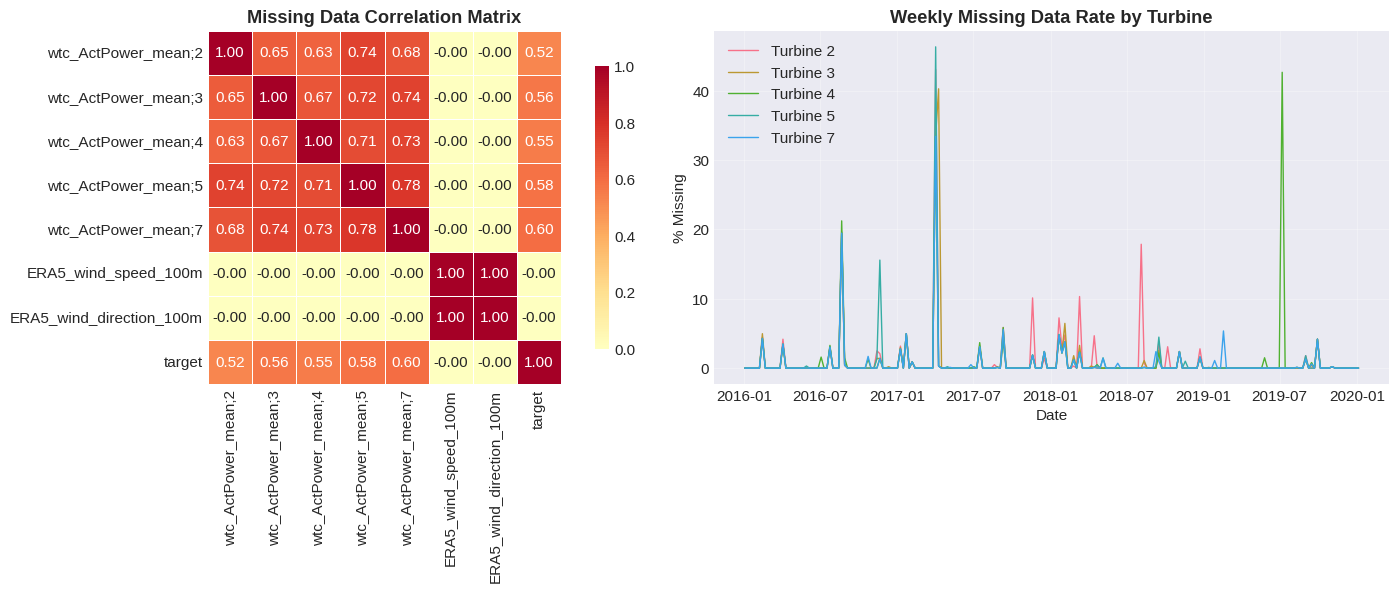

In [33]:
# Analyze missing data patterns
print("🔍 Missing Data Analysis")
print("="*60)

# Calculate missing percentages for each turbine
missing_by_turbine = {}
for turbine_id in TURBINE_IDS:
    turbine_cols = [col for col in train_df.columns if col.endswith(f';{turbine_id}')]
    if turbine_cols:
        missing_pct = train_df[turbine_cols].isnull().mean().mean() * 100
        missing_by_turbine[turbine_id] = missing_pct

print("\n📊 Missing Data by Turbine:")
for turbine_id, pct in sorted(missing_by_turbine.items()):
    print(f"  Turbine {turbine_id}: {pct:.2f}%")

# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Missing data heatmap for key columns
key_cols = [f'wtc_ActPower_mean;{tid}' for tid in OTHER_TURBINE_IDS if f'wtc_ActPower_mean;{tid}' in train_df.columns]
key_cols += ['ERA5_wind_speed_100m', 'ERA5_wind_direction_100m', TARGET_COL]

missing_matrix = train_df[key_cols].isnull().astype(int)
missing_corr = missing_matrix.corr()

sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=axes[0])
axes[0].set_title('Missing Data Correlation Matrix', fontweight='bold')

# 2. Missing data over time
daily_missing = train_df.set_index('TimeStamp').isnull().resample('W').mean()
for turbine_id in OTHER_TURBINE_IDS:
    col = f'wtc_ActPower_mean;{turbine_id}'
    if col in daily_missing.columns:
        axes[1].plot(daily_missing.index, daily_missing[col] * 100, 
                    label=f'Turbine {turbine_id}', linewidth=1)

axes[1].set_xlabel('Date')
axes[1].set_ylabel('% Missing')
axes[1].set_title('Weekly Missing Data Rate by Turbine', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Feature Importance Preview

🎯 Feature Importance Analysis

Analyzing 156 features (excluding Turbine 1)...


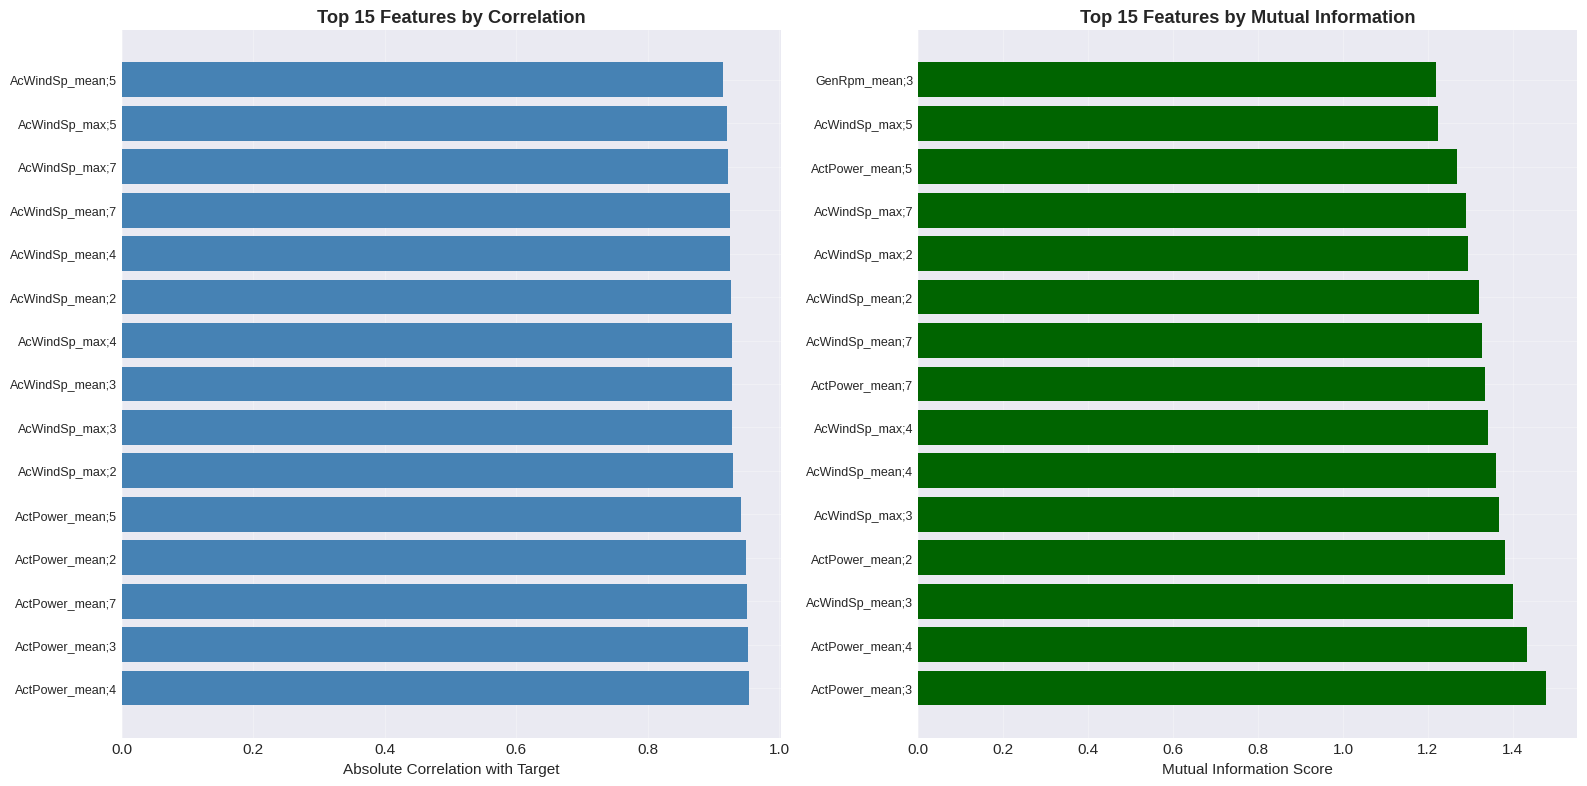


📊 Top 10 Most Important Features:

By Correlation:
  1. wtc_ActPower_mean;4: 0.9545
  2. wtc_ActPower_mean;3: 0.9522
  3. wtc_ActPower_mean;7: 0.9509
  4. wtc_ActPower_mean;2: 0.9494
  5. wtc_ActPower_mean;5: 0.9425
  6. wtc_AcWindSp_max;2: 0.9292
  7. wtc_AcWindSp_max;3: 0.9290
  8. wtc_AcWindSp_mean;3: 0.9289
  9. wtc_AcWindSp_max;4: 0.9282
  10. wtc_AcWindSp_mean;2: 0.9264

By Mutual Information:
  2. wtc_AcWindSp_mean;3: 1.3999
  3. wtc_AcWindSp_mean;4: 1.3607
  5. wtc_AcWindSp_mean;7: 1.3263
  1. wtc_AcWindSp_mean;2: 1.3193


In [34]:
# Quick feature importance using correlation and mutual information
from sklearn.feature_selection import mutual_info_regression

print("🎯 Feature Importance Analysis")
print("="*60)

# Select features for analysis (exclude Turbine 1 features)
feature_cols = []
for col in train_df.columns:
    if col.endswith(';1'):  # Skip Turbine 1 features
        continue
    if col in [TARGET_COL, 'TimeStamp', 'TimeStamp_StartFormat', 'id', 'is_valid', 
              'hour', 'day', 'month', 'year', 'dayofweek', 'quarter']:
        continue
    if train_df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int16']:
        feature_cols.append(col)

print(f"\nAnalyzing {len(feature_cols)} features (excluding Turbine 1)...")

# Use valid data only
valid_features = train_df[train_df['is_valid']][feature_cols + [TARGET_COL]].dropna()

# Calculate correlations
correlations = valid_features.corr()[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)

# Calculate mutual information (on a sample for speed)
if len(valid_features) > 10000:
    sample = valid_features.sample(10000, random_state=42)
else:
    sample = valid_features

X_sample = sample[feature_cols]
y_sample = sample[TARGET_COL]

# Impute missing values for MI calculation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_sample)

mi_scores = mutual_info_regression(X_imputed, y_sample, random_state=42)
mi_df = pd.DataFrame({'feature': feature_cols, 'mi_score': mi_scores}).sort_values('mi_score', ascending=False)

# Combine and visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top correlations
top_corr = correlations.head(15)
axes[0].barh(range(len(top_corr)), top_corr.values, color='steelblue')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels([col.replace('wtc_', '').replace('ERA5_', 'ERA5:') for col in top_corr.index], fontsize=9)
axes[0].set_xlabel('Absolute Correlation with Target')
axes[0].set_title('Top 15 Features by Correlation', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Top MI scores
top_mi = mi_df.head(15)
axes[1].barh(range(len(top_mi)), top_mi['mi_score'].values, color='darkgreen')
axes[1].set_yticks(range(len(top_mi)))
axes[1].set_yticklabels([col.replace('wtc_', '').replace('ERA5_', 'ERA5:') for col in top_mi['feature'].values], fontsize=9)
axes[1].set_xlabel('Mutual Information Score')
axes[1].set_title('Top 15 Features by Mutual Information', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
print("\n📊 Top 10 Most Important Features:")
print("\nBy Correlation:")
for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
    print(f"  {i}. {feat}: {corr:.4f}")

print("\nBy Mutual Information:")
for i, row in mi_df.head(10).iterrows():
    if i < 10:
        print(f"  {i+1}. {row['feature']}: {row['mi_score']:.4f}")

## 11. Key Insights and Recommendations

In [35]:
print("🎯 KEY INSIGHTS AND RECOMMENDATIONS")
print("="*60)

print("\n📊 Data Summary:")
print(f"  • Training period: {train_df['TimeStamp'].min().date()} to {train_df['TimeStamp'].max().date()}")
print(f"  • Test period: {test_df['TimeStamp_StartFormat'].min().date()} to {test_df['TimeStamp_StartFormat'].max().date()}")
print(f"  • Target: Turbine 1 Active Power (clipped at 0)")
print(f"  • Available predictors: Turbines {OTHER_TURBINE_IDS} + ERA5 weather data")
print(f"  • Evaluation: MAE on valid periods only ({train_valid_pct:.1f}% of training data)")

print("\n🔍 Critical Findings:")
print(f"  1. Target column is 'target', not 'wtc_PowerRef_endvalue;1'")
print(f"  2. Must filter by is_valid=True for proper scoring")
print(f"  3. Cannot use Turbine 1 features in training (not available in test)")
print(f"  4. High correlation between turbines (>{target_corr_others.max():.3f})")
print(f"  5. Clear power curves with rated power ~{valid_target.max():.0f} kW")
print(f"  6. Seasonal patterns present (best: Q{quarterly_avg['mean'].idxmax()})")

print("\n💡 Feature Engineering Recommendations:")
print("  1. Use neighboring turbine power as primary features")
print("  2. Create wind shear feature (100m/10m wind speed ratio)")
print("  3. Add temporal features (hour, month, season)")
print("  4. Engineer lag features for time series patterns")
print("  5. Consider turbine operational status features")
print("  6. Aggregate features across turbine groups")

print("\n🤖 Modeling Strategy:")
print("  1. Baseline: Average of other operating turbines")
print("  2. Tree-based models (XGBoost, LightGBM) for non-linear patterns")
print("  3. Time series models for temporal dependencies")
print("  4. Ensemble multiple approaches")
print("  5. Use time-based cross-validation")

print("\n⚠️  Important Reminders:")
print("  • Filter training data by is_valid=True for target")
print("  • Exclude all ;1 columns from features")
print("  • Handle missing data appropriately")
print("  • Consider wake effects between turbines")
print("  • Account for seasonal wind patterns")

🎯 KEY INSIGHTS AND RECOMMENDATIONS

📊 Data Summary:
  • Training period: 2016-01-01 to 2019-12-31
  • Test period: 2020-01-01 to 2020-12-31
  • Target: Turbine 1 Active Power (clipped at 0)
  • Available predictors: Turbines [2, 3, 4, 5, 7] + ERA5 weather data
  • Evaluation: MAE on valid periods only (95.7% of training data)

🔍 Critical Findings:
  1. Target column is 'target', not 'wtc_PowerRef_endvalue;1'
  2. Must filter by is_valid=True for proper scoring
  3. Cannot use Turbine 1 features in training (not available in test)
  4. High correlation between turbines (>1.000)
  5. Clear power curves with rated power ~2305 kW
  6. Seasonal patterns present (best: Q4)

💡 Feature Engineering Recommendations:
  1. Use neighboring turbine power as primary features
  2. Create wind shear feature (100m/10m wind speed ratio)
  3. Add temporal features (hour, month, season)
  4. Engineer lag features for time series patterns
  5. Consider turbine operational status features
  6. Aggregate feat

## 12. Save Processed Data

In [36]:
# Prepare and save processed datasets
print("💾 Saving Processed Data")
print("="*60)

# Create feature sets
def prepare_features(df, is_train=True):
    """Prepare features excluding Turbine 1 data"""
    # Exclude Turbine 1 features and metadata columns
    exclude_cols = ['TimeStamp', 'TimeStamp_StartFormat', 'id', 'is_valid', TARGET_COL,
                   'hour', 'day', 'month', 'year', 'dayofweek', 'quarter']
    
    features = []
    for col in df.columns:
        if col in exclude_cols:
            continue
        if col.endswith(';1'):  # Skip Turbine 1 features
            continue
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int16']:
            features.append(col)
    
    return features

# Get feature list
train_features = prepare_features(train_df)
test_features = prepare_features(test_df)

# Common features
common_features = list(set(train_features) & set(test_features))
print(f"\nCommon features: {len(common_features)}")
print(f"Train-only features: {len(set(train_features) - set(test_features))}")
print(f"Test-only features: {len(set(test_features) - set(train_features))}")

# Save feature list
import json
feature_info = {
    'common_features': common_features,
    'train_features': train_features,
    'test_features': test_features,
    'target_column': TARGET_COL,
    'metadata_columns': ['TimeStamp_StartFormat', 'id', 'is_valid']
}

with open('../data/processed/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("\n✅ Feature information saved to data/processed/feature_info.json")

# Save key statistics
stats = {
    'train_samples': len(train_df),
    'test_samples': len(test_df),
    'train_valid_pct': train_valid_pct,
    'test_valid_pct': test_valid_pct,
    'target_mean': float(valid_target.mean()),
    'target_std': float(valid_target.std()),
    'target_min': float(valid_target.min()),
    'target_max': float(valid_target.max()),
    'n_features': len(common_features),
    'turbines_available': OTHER_TURBINE_IDS
}

with open('../data/processed/data_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)

print("✅ Data statistics saved to data/processed/data_stats.json")

print("\n🎉 EDA Complete! Ready for feature engineering and modeling.")

💾 Saving Processed Data

Common features: 156
Train-only features: 0
Test-only features: 0

✅ Feature information saved to data/processed/feature_info.json
✅ Data statistics saved to data/processed/data_stats.json

🎉 EDA Complete! Ready for feature engineering and modeling.
